## Main Question
We will predict sales for the thousands of product families sold at Favorita stores located in Ecuador.

### Data Understanding
The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers.  
Additional files include supplementary information that may be useful in building your models. 

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales:

1. **store_nbr** identifies the store at which the products are sold.
2. **family** identifies the type of product sold.
3. **sales** gives the total sales **for a product family at a particular store at a given date**. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
4. **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

### Exploratory Data Analysis

In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv("Datasets/Ecuador_sales_record_train.csv")

In [6]:
dataset.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [8]:
# Checking Missing Values
dataset.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [9]:
dataset.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [10]:
# Converting the String format of DATE to datetime object for TimeSeries Analysis.
dataset['date'] = pd.to_datetime(dataset['date'])

In [12]:
# Setting the 'date' column as the index of the DataFrame.
dataset.set_index('date', inplace=True)
# Sorting it to make sure all records are in chronological order.
dataset.sort_index(inplace=True)

In [13]:
dataset.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


**Visualizing Overall Sales Trends**

In [ ]:
# Aggregating 'sales' column by date/month (the dataset is large so we choose aggregating by month) to get total sales per month.
# Monthly Sales Plot
dataset_monthly_sales = dataset['sales'].resample('ME').sum()
# The resample() method is specifically designed for time series data and allows you to change the frequency of your data. 
# D (daily), W (weekly), ME (monthly), YE (yearly)

<Axes: title={'center': 'Total Monthly Sales Over Time'}, xlabel='date'>

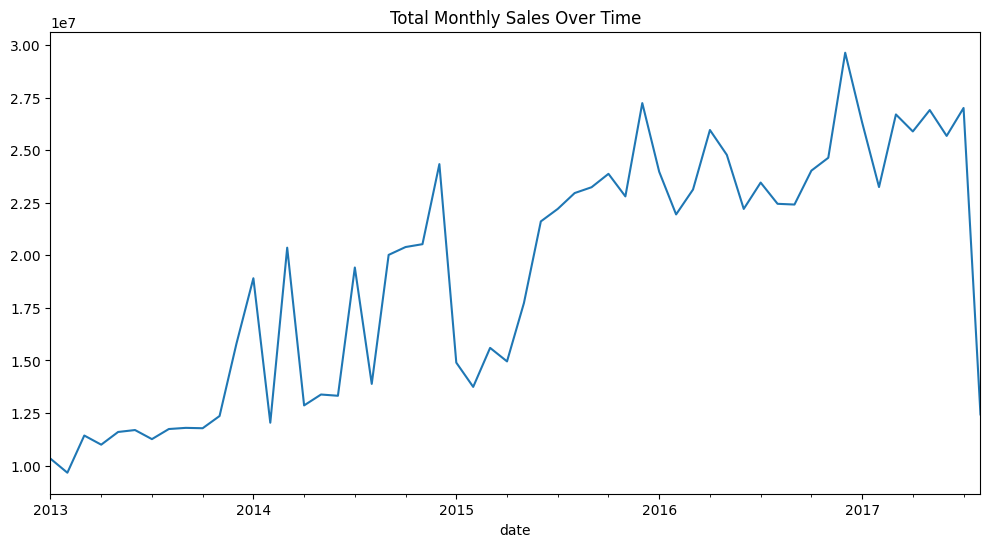

In [17]:
dataset_monthly_sales.plot(title="Total Monthly Sales Over Time", figsize=(12, 6))

**Visualizing Sales Trends by Product Family or Store**

In [23]:
# We can also break down sales by family or store_nbr to explore trends specific to product categories or stores. 
# Here we groupping by 'family' to see if there is specific trends to product categories.
dataset_family_sales = dataset.groupby(['family']).resample('YE').sum()['sales'].unstack(0)

<Axes: title={'center': 'Yearly Sales by Product Family Over Time'}, xlabel='date'>

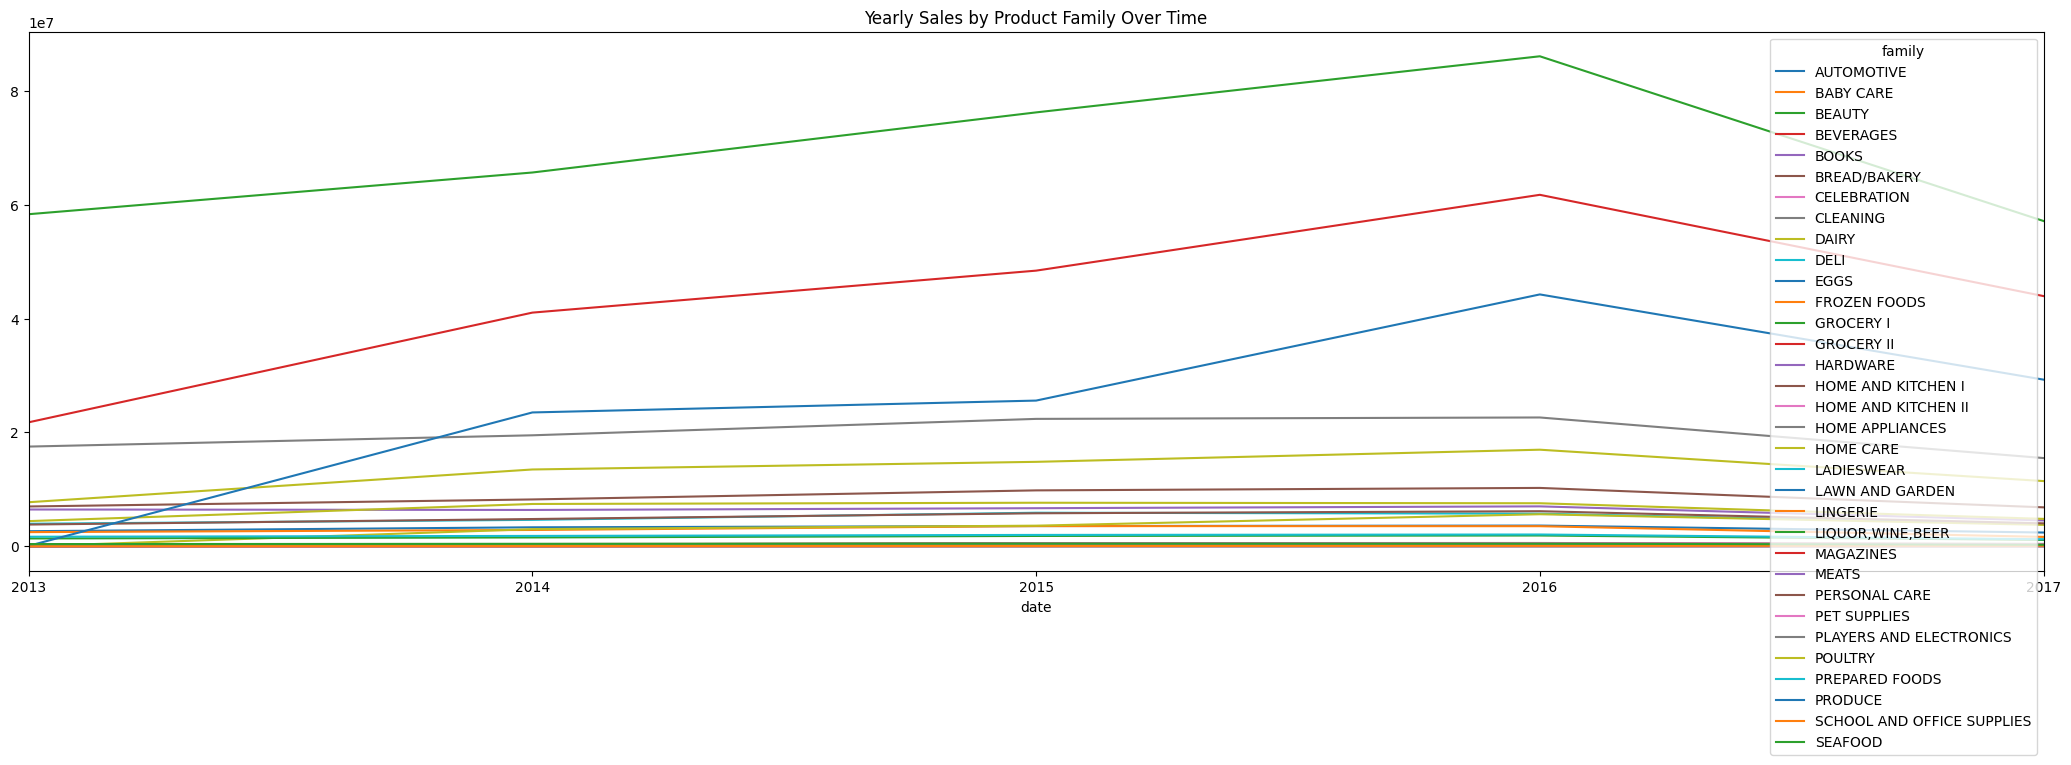

In [25]:
dataset_family_sales.plot(title='Yearly Sales by Product Family Over Time', figsize=(26, 7))